In [17]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [18]:

from langgraph.graph.message import StateGraph
from langgraph.graph import START, END
from langchain_groq import ChatGroq
from typing_extensions import TypedDict

In [19]:
class State(TypedDict):
    question: int
    agent1_response: int
    agent2_response: int
    agent3_response: int
    aggregator_response: int

In [20]:
def agent1(state:State):
    """addition"""
    question = state['question']
    response = question +5
    return {"agent1_response":response}

def agent2(state:State):
    """subtraction"""
    question = state['question']
    response = question -5
    return {"agent2_response":response}

def agent3(state:State):
    """multiplication"""
    question = state['question']
    response = question * 5
    return {"agent3_response":response}

def aggregator(state:State):
    agent1_response = state['agent1_response']
    agent2_response = state['agent2_response']
    agent3_response = state['agent3_response']

    response = f"response from agent 1 : {agent1_response} \n response from agent 2: {agent2_response} \n response from agent3 : {agent3_response}"
    return {"aggregator_response":response}

In [21]:
graph = StateGraph(State)

In [22]:
graph.add_node("agent_1",agent1)
graph.add_node("agent_2",agent2)
graph.add_node("agent_3",agent3)
graph.add_node("aggregators",aggregator)


graph.add_edge(START,"agent_1")
graph.add_edge(START,"agent_2")
graph.add_edge(START,"agent_3")

graph.add_edge("agent_1","aggregators")
graph.add_edge("agent_2","aggregators")
graph.add_edge("agent_3","aggregators")

graph.add_edge("aggregators",END)

In [23]:
app = graph.compile()

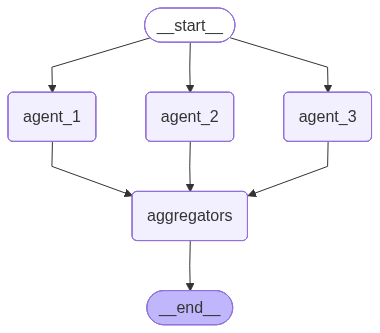

In [24]:
app

In [25]:
response = app.invoke({"question":5})

In [26]:
print(response['aggregator_response'],end=" ")

response from agent 1 : 10 
 response from agent 2: 0 
 response from agent3 : 25 

In [27]:
from typing import TypedDict
import asyncio
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    question: int
    agent1_response: int
    agent2_response: int
    agent3_response: int
    aggregator_response: str

async def agent1_task(question: int):
    """addition"""
    return question + 5

async def agent2_task(question: int):
    """subtraction"""
    return question - 5

async def agent3_task(question: int):
    """multiplication"""
    return question * 5

async def parallel_agents(state: State):
    """Execute all agents in parallel and aggregate results"""
    question = state['question']
    
    # Run all agents concurrently
    agent1_response, agent2_response, agent3_response = await asyncio.gather(
        agent1_task(question),
        agent2_task(question),
        agent3_task(question)
    )
    
    # Aggregate responses
    aggregator_response = f"response from agent 1 : {agent1_response} \n response from agent 2: {agent2_response} \n response from agent3 : {agent3_response}"
    
    return {
        "agent1_response": agent1_response,
        "agent2_response": agent2_response,
        "agent3_response": agent3_response,
        "aggregator_response": aggregator_response
    }

# Build graph
graph = StateGraph(State)
graph.add_node("parallel_agents", parallel_agents)
graph.add_edge(START, "parallel_agents")
graph.add_edge("parallel_agents", END)

app = graph.compile()

# Test
response = await app.ainvoke({"question": 5})
print(response)

{'question': 5, 'agent1_response': 10, 'agent2_response': 0, 'agent3_response': 25, 'aggregator_response': 'response from agent 1 : 10 \n response from agent 2: 0 \n response from agent3 : 25'}
